# Project Report

# **Using age, cholesterol and heart rate to classify heart disease patients from Cleveland.**
#### Shreya Arora, Youssef Saleh, Zahra Vink.

### Introduction
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate (Cleveland Clinic, n.d.).

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has heart disease, their maximum heart rate could significantly decrease (WebMD, 2002). 

Thus, our question is: **Is a new patient likely to have heart disease, based on cholesterol levels and maximum heart rate achieved?** To answer this, we will use a knn classifier algorithm.

We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Each column is numeric-valued and there are 303 rows, with missing data represented as the string "?".

Based on the list above, we will be using `chol` and `thalach` as predictors, to classify patients on whether or not they have heart disease.

### Preprocessing and exploratory data analysis

#### Importing libraries

In [2]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Importing the dataframe

We used `read_csv` to import the processed.cleveland.data dataframe from the online directory.

In [17]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                          col_names = FALSE)

head(cleveland_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


As you can see above, the dataframe does not come with column names, so those must be added. Some factor columns are also being read as `<dbl>` or `<chr>`, so those need to be changed as well.

#### Cleaning and tidying the data

The reason some columns are being read as \<chr> is because they include "?" for unknown values, so we will change those to NA so they can be changed to the types we need.

For this data to be used for a classifier, we need to have a true/false column based on **num**, which we will call **diag**.

In [23]:
set.seed(1)
# assigning col names
cleveland_clean <- cleveland_data

colnames(cleveland_clean) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
                           
# changing "?" into NA
cleveland_data[ cleveland_data == "?" ] <- NA

# adding diag column, setting col types
# as.integer is being used to get rid of decimal points when switching to factor
cleveland_clean <- cleveland_data %>%
                    mutate(diag = as.factor(ifelse(is.na(num), NA, (num > 0)))) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope))) %>%
                    mutate(num = as_factor(num))

head(cleveland_clean)


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,FALSE


Now our table is clean and tidy!

Since `num` uses integers to distinguish presence (1,2,3,4) from absence (0), and we want to determine *whether or not* a patient has heart disease, a new boolean column `diag` has been appended to narrow diagnoses down to TRUE or FALSE. To stratify by it, we made it a factor column.

#### Splitting our data into training and testing sets

Before working on our model, we need to split our data into training and testing sets. Since we want to predict the new column `diag`, we will be stratifying by it.

We will use `initial_split` to split our dataframe into 75% training and 25% testing, since it shuffles our data for us and ensures an equal proportion of each class is present in both. The 75-25 split allows us to train our model on as many data points as possible while also keeping enough data for effective testing later.

In [4]:
#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE


In the above code, we split the data into a training set to build our model on, and a testing set to, *well*, test it. Using `initial_split` allowed us to shuffle the data before splitting (removing bias and order) and stratify the data by `diag` so that an equal proportion of it in each set.

Moving forward, we will only use the training set until the very end.

#### Summarizing the data

Before we get to work, we need to make sure that the two classes actually have different averages in age, serum cholersterol and maximum heart rate achieved.

To do this, we will use `group_by` and `summarize` to create a table with the minimum, maximum and mean of each of our predictors.

In [24]:
#summarizing to get min, max, mean of each predictor + total no. of rows per class
cleveland_summary <- cleveland_training %>%
                    group_by(diag) %>%
                    summarize(min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

`summarise()` ungrouping output (override with `.groups` argument)



diag,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,141,417,241.2439,96,202,157.6179,123
TRUE,131,353,252.6857,90,182,139.4095,105


To summarize our data, we grouped by `diag` then summarized for the minimum, maximum and mean of `chol` and `thalach`.

We can see that patients with heart disease tend to have higher cholesterol and lower maximum heart rates.

#### Visualizing the realtionship between predictors and class

To visualize the relationship that cholesterol and maximum heart rate achieved have with a patient's diagnosis, we will use `ggplot` to generate a scatter plot of `chol` vs `thalach`, coloring for `diag` 

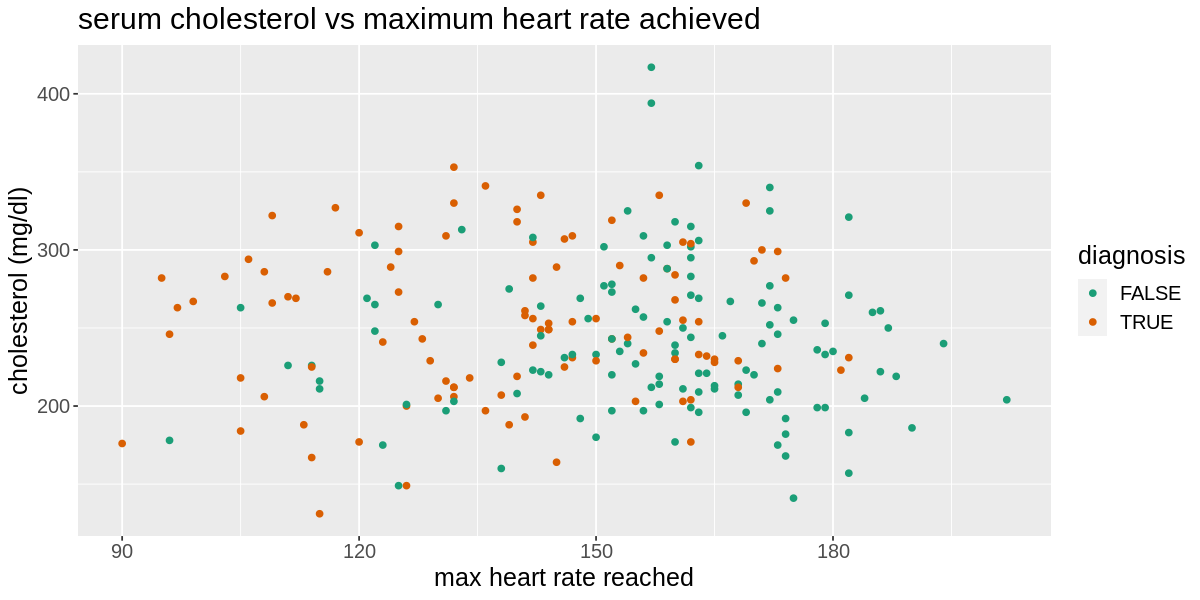

In [44]:
#plotting the training data
chol_thalach <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)",
                      color = "diagnosis", title = "serum cholesterol vs maximum heart rate achieved") +
                 scale_color_brewer(palette = "Dark2") +
                 theme(text = element_text(size = 15))


chol_thalach

This graphs shows that patients with heart disease (orange) tend to have lower maximum heart rates and higher cholesterol, with patients without heart disease (teal) having higher maximum heart rates and a wider range of cholesterol levels.

### Methods
**Finding Best K Value**

Methods for finding the best K value: 
Our goal is to find the best value for the K-nearest neighbours, providing the highest accuracy and better predictions. We had already split the data into a training and testing set initially, so in the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data.

1) First, we use the recipe function, which preprocesses the data centered, scaled and balanced. 

2) Then we performed the cross-validation with ten folds using the vfold_cv function on the training data. We used ten folds because if we split the data once, the results strongly depend on the observations that ended up being in the validation set, so using more folds increases the accuracy.

3) Then we created a k nearest model but replaced neighbours=tune instead of an actual value since we are trying to find the best k-nearest neighbours value. 

4) We add the recipe and model to a workflow using workflow().Tune_grid function runs cross validation on a range of k nearest neighbours values that is specified in gridvals

5) Then we find the best K value by filtering for the accuracy and plotting a scatter plot with the accuracy estimate on the y axis and k nearest neighbour value on the x-axis. 

**Building Our Classifier**

1)

2)

In [39]:
set.seed(1)

# Performing Standardization 
cleveland_recipe <- recipe(diag ~ chol + thalach , data = cleveland_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

# Perform 10 fold-cross valdiation 
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diag)

# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

gridvals <- tibble(neighbors = c(1:100))

# Create new workflow using new knn_tune 
knn_results <- workflow() %>%
      add_recipe(cleveland_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = cleveland_vfold, grid = gridvals) %>%
      collect_metrics()

#knn_results

In [40]:
options(repr.plot.width = 10, repr.plot.height = 5)

#To find best k value filter for accuracies and graph
accuracies <- knn_results %>% 
      filter(.metric == "accuracy") %>%
      select(neighbors, mean) %>%
      arrange(desc(mean))
     
accuracies_plot <- accuracies %>%
slice(1,2,3,4,5,6)
accuracies_plot

neighbors,mean
<int>,<dbl>
73,0.7038702
74,0.7038702
83,0.6987813
84,0.6987813
57,0.6949769
77,0.6947958


The plot above shows the first 6 k-nearest neighbour values that will provide the highest accuracy of the classifier. According to this table 73 as our k value gives us around 70.387% accuracy. 

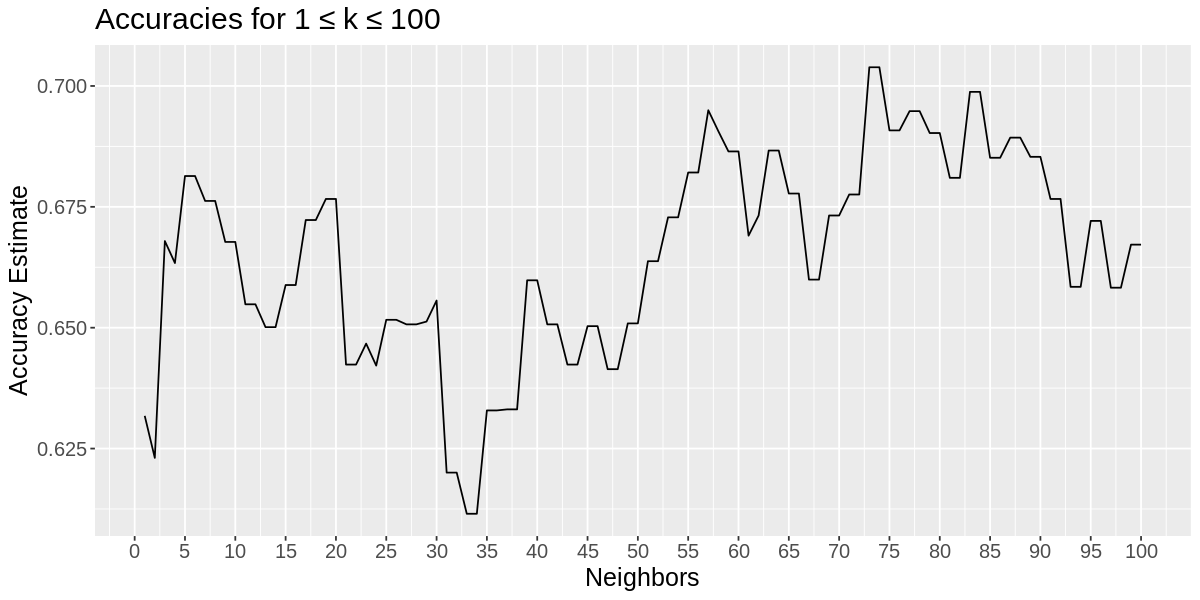

In [43]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 100") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

**Looking at the graph above, $k$ = 73 give us the best accuracy, at 70%**. The graph above plots the number of neighbours on the x-axis and the accuracy estimate on the y-axis.

In [35]:
set.seed(1)

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 73)%>%
    set_engine("kknn")%>%
    set_mode("classification")

fit <- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = cleveland_training)

train_predictions <- predict(fit, cleveland_training)%>%
    bind_cols(cleveland_training)

thalach_grid <- seq(min(cleveland_clean$thalach), 
                max(cleveland_clean$thalach), 
                length.out = 100)

chol_grid <- seq(min(cleveland_clean$chol), 
                max(cleveland_clean$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                chol = chol_grid))

knnPredGrid <- predict(fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
                    rename(diag = .pred_class)


plot_results <- ggplot() + 
                geom_point(data = train_predictions, 
                mapping = aes(x = thalach, y = chol, color = diag), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = thalach, 
                           y = chol, 
                           color = diag), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 15))

In [36]:
#Comparing accuracy of classifier with majority classifier
cleveland_proportions <-cleveland_training %>%
    group_by(diag) %>%
    summarize(n=n()) %>%
    mutate(percent = 100*n/nrow(cleveland_training))
cleveland_proportions

`summarise()` ungrouping output (override with `.groups` argument)



diag,n,percent
<fct>,<int>,<dbl>
FALSE,123,53.94737
TRUE,105,46.05263


In the code cell above we used group_by and summarize to obtain the percentage of each class in the training set. From here we can deduce that a FALSE diagnosis represents the majority of the training data (53.9%).  Therefore, the majority classifier will most likely have 53.9% accuracy since it will always predict the majority class.

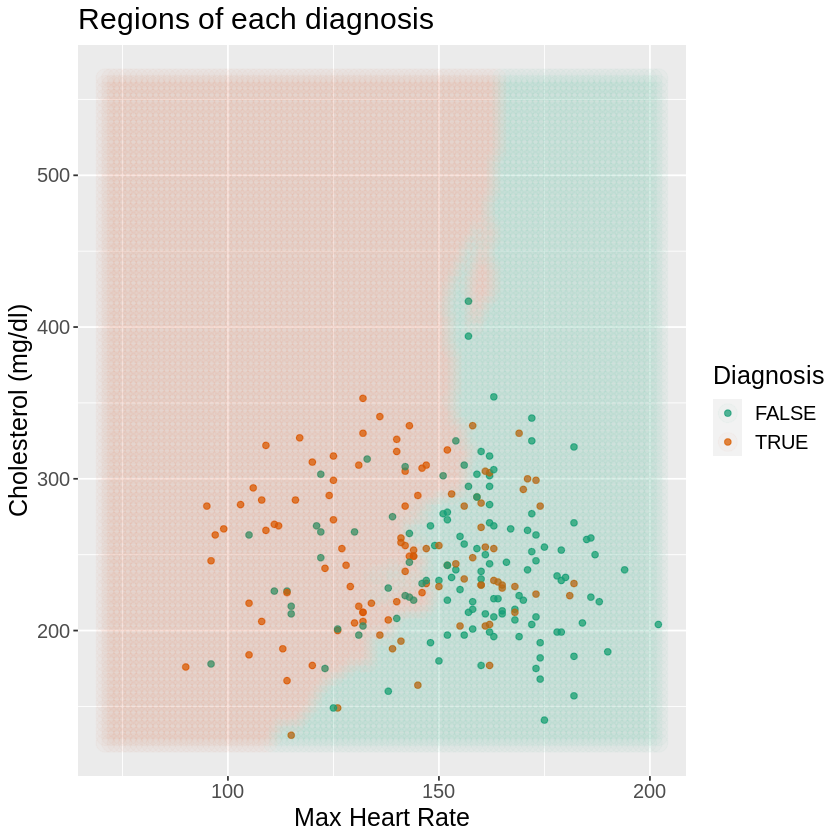

In [37]:
plot_results

We plotted the graph above to tell us whether our the classifier results in overfitting or underfitting which can cause our classifier to become unreliable on new data. Looking at the graph above the classifer is neither underfitting or overfitting and therefore we can trust that our classifier will be able to predict new data. 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
TRUE,56,0,2,140,294,0,2,153,0,1.3,2,1,2,0,FALSE
TRUE,64,1,1,110,211,0,2,144,1,1.8,2,1,2,0,FALSE
FALSE,43,1,4,150,247,0,0,171,0,1.5,1,1,2,0,FALSE
FALSE,69,0,1,140,239,0,0,151,0,1.8,1,3,2,0,FALSE
FALSE,59,1,4,135,234,0,0,161,0,0.5,2,1,3,0,FALSE
FALSE,42,1,4,140,226,0,0,178,0,0.0,1,1,2,0,FALSE


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
FALSE,67,1,3,152,212,0,2,150,0,0.8,2,1,3,1,TRUE
FALSE,55,0,2,132,342,0,0,166,0,1.2,1,1,2,0,FALSE
FALSE,44,1,4,120,169,0,0,144,1,2.8,3,1,1,2,TRUE
FALSE,63,1,4,140,187,0,2,144,1,4.0,1,3,3,2,TRUE
TRUE,45,1,1,110,264,0,0,132,0,1.2,2,1,3,1,TRUE
FALSE,57,0,2,130,236,0,2,174,0,0.0,2,4,2,1,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.68


          Truth
Prediction FALSE TRUE
     FALSE    33   16
     TRUE      8   18

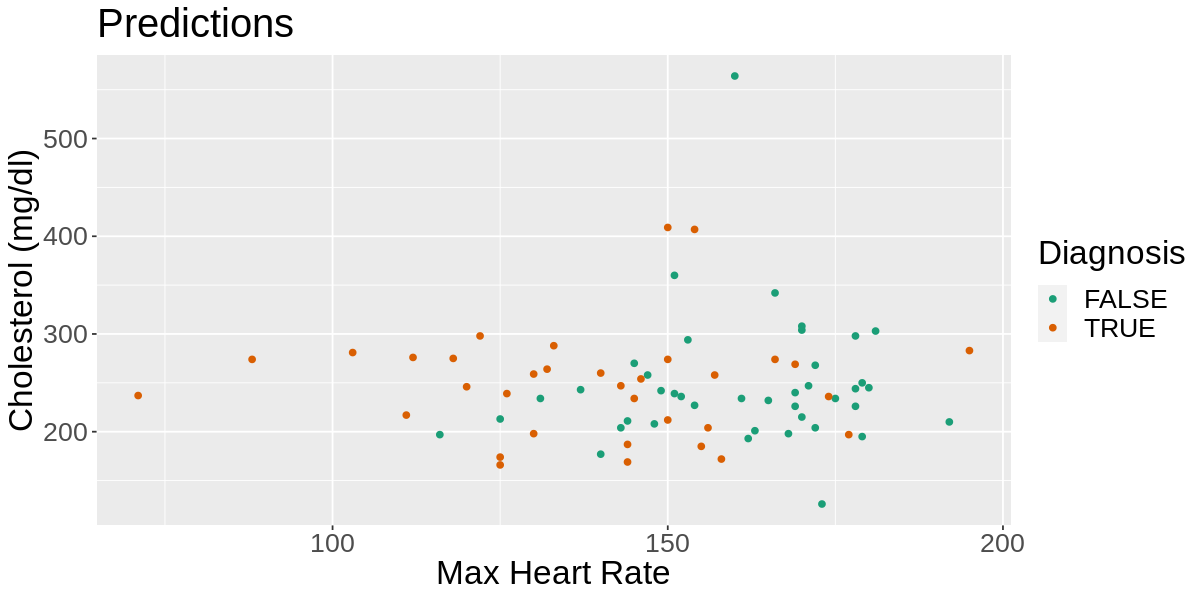

In [12]:
set.seed(1)

#predict
predictions<- predict(fit, cleveland_testing)%>%
    bind_cols(cleveland_testing)

head(predictions)
tail(predictions)

#find the accuracy of the predictions
metrics<- predictions %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions %>%
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

#visualizing results

plot_results <- ggplot(predictions, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 ggtitle("Predictions")+
                 scale_color_brewer(palette = "Dark2")+
                 theme(text = element_text(size = 20))
plot_results

### Discussion

### Bibliography

Detecting and Treating Heart Failure. (2002, November 1). WebMD. https://www.webmd.com/heart-disease/heart-failure/understanding-heart-failure-treatment.

Preventing & reversing cardiovascular disease. Cleveland Clinic. (n.d.). Retrieved November 6, 2021, from https://my.clevelandclinic.org/health/articles/17385-cardiovascular-disease-prevention--reversal. 

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019, April 27). Cardiovascular risks associated with gender and aging. Journal of cardiovascular development and disease. Retrieved November 10, 2021, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/.

The creators of the Heart Disease Database are:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.